# Analysing IPL Cricket Data 

https://www.kaggle.com/vaishaligarg/analysing-ipl-data

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/matches.csv")
matches["type"] = "pre-qualifier"

for year in range(2008, 2017):
   final_match_index = matches[matches['season']==year][-1:].index.values[0]
   matches = matches.set_value(final_match_index, "type", "final")
   matches = matches.set_value(final_match_index-1, "type", "qualifier-2")
   matches = matches.set_value(final_match_index-2, "type", "eliminator")
   matches = matches.set_value(final_match_index-3, "type", "qualifier-1")

matches.groupby(["type"])["id"].count()
matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,type
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN,pre-qualifier
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN,pre-qualifier
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN,pre-qualifier
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN,pre-qualifier
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN,pre-qualifier


In [0]:
deliveries = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/deliveries.csv")
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,1,SC Ganguly,BB McCullum,P Kumar,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
1,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,2,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,3,BB McCullum,SC Ganguly,P Kumar,0,1,0,0,0,0,0,1,1,NaN,NaN,NaN
3,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,4,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,5,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


# Add team score and team extra columns for each match, each inning.

In [0]:
team_score = deliveries.groupby(['match_id', 'inning'])['total_runs'].sum().unstack().reset_index()
team_score.columns = ['match_id', 'Team1_score', 'Team2_score', 'Team1_superover_score', 'Team2_superover_score']
matches_agg = pd.merge(matches, team_score, left_on = 'id', right_on = 'match_id', how = 'outer')

team_extras = deliveries.groupby(['match_id', 'inning'])['extra_runs'].sum().unstack().reset_index()
team_extras.columns = ['match_id', 'Team1_extras', 'Team2_extras', 'Team1_superover_extras', 'Team2_superover_extras']
matches_agg = pd.merge(matches_agg, team_extras, on = 'match_id', how = 'outer')

#Reorder the columns to make the data more readable
cols = ['match_id', 'season','city','date','team1','team2', 'toss_winner', 'toss_decision', 'result', 'dl_applied', 'winner', 'Team1_score','Team2_score', 'win_by_runs', 'win_by_wickets', 'Team1_extras', 'Team2_extras', 'Team1_superover_score', 'Team2_superover_score', 'Team1_superover_extras', 'Team2_superover_extras', 'player_of_match', 'type', 'venue', 'umpire1', 'umpire2', 'umpire3']
matches_agg = matches_agg[cols]
matches_agg.head(2)

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,Team1_score,Team2_score,win_by_runs,win_by_wickets,Team1_extras,Team2_extras,Team1_superover_score,Team2_superover_score,Team1_superover_extras,Team2_superover_extras,player_of_match,type,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,222.0,82.0,140,0,17.0,19.0,NaN,NaN,NaN,NaN,BB McCullum,pre-qualifier,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,240.0,207.0,33,0,6.0,11.0,NaN,NaN,NaN,NaN,MEK Hussey,pre-qualifier,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN


# Batsmen aggregates (Runs, Balls, 4s, 6s, SR)

In [0]:
batsman_grp = deliveries.groupby(["match_id", "inning", "batting_team", "batsman"])
batsmen = batsman_grp["batsman_runs"].sum().reset_index()

# Ignore the wide balls.
balls_faced = deliveries[deliveries["wide_runs"] == 0]
balls_faced = balls_faced.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
balls_faced.columns = ["match_id", "inning", "batsman", "balls_faced"]
batsmen = batsmen.merge(balls_faced, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

fours = deliveries[ deliveries["batsman_runs"] == 4]
sixes = deliveries[ deliveries["batsman_runs"] == 6]

fours_per_batsman = fours.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
sixes_per_batsman = sixes.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()

fours_per_batsman.columns = ["match_id", "inning", "batsman", "4s"]
sixes_per_batsman.columns = ["match_id", "inning", "batsman", "6s"]

batsmen = batsmen.merge(fours_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen = batsmen.merge(sixes_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen['SR'] = np.round(batsmen['batsman_runs'] / batsmen['balls_faced'] * 100, 2)

for col in ["batsman_runs", "4s", "6s", "balls_faced", "SR"]:
    batsmen[col] = batsmen[col].fillna(0)

dismissals = deliveries[ pd.notnull(deliveries["player_dismissed"])]
dismissals = dismissals[["match_id", "inning", "player_dismissed", "dismissal_kind", "fielder"]]
dismissals.rename(columns={"player_dismissed": "batsman"}, inplace=True)
batsmen = batsmen.merge(dismissals, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

batsmen = matches[['id','season']].merge(batsmen, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)
batsmen.head(2)

,season,match_id,inning,batting_team,batsman,batsman_runs,balls_faced,4s,6s,SR,dismissal_kind,fielder
0,2008,1,1,Kolkata Knight Riders,BB McCullum,158,73.0,10.0,13.0,216.44,NaN,NaN
1,2008,1,1,Kolkata Knight Riders,DJ Hussey,12,12.0,1.0,0.0,100.00,caught,CL White


# Bowler Aggregates

In [0]:
bowler_grp = deliveries.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])
bowlers = bowler_grp["total_runs", "wide_runs", "bye_runs", "legbye_runs", "noball_runs"].sum().reset_index()

bowlers["runs"] = bowlers["total_runs"] - (bowlers["bye_runs"] + bowlers["legbye_runs"])
bowlers["extras"] = bowlers["wide_runs"] + bowlers["noball_runs"]

del( bowlers["bye_runs"])
del( bowlers["legbye_runs"])
del( bowlers["total_runs"])

dismissal_kinds_for_bowler = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals = deliveries[deliveries["dismissal_kind"].isin(dismissal_kinds_for_bowler)]
dismissals = dismissals.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])["dismissal_kind"].count().reset_index()
dismissals.rename(columns={"dismissal_kind": "wickets"}, inplace=True)

bowlers = bowlers.merge(dismissals, left_on=["match_id", "inning", "bowling_team", "bowler", "over"], 
                        right_on=["match_id", "inning", "bowling_team", "bowler", "over"], how="left")
bowlers["wickets"] = bowlers["wickets"].fillna(0)

bowlers_over = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler'])['over'].count().reset_index()
bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler']).sum().reset_index().drop('over', 1)
bowlers = bowlers_over.merge(bowlers, on=["match_id", "inning", "bowling_team", "bowler"], how = 'left')
bowlers['Econ'] = np.round(bowlers['runs'] / bowlers['over'] , 2)
bowlers = matches[['id','season']].merge(bowlers, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)

bowlers.head(2)

,season,match_id,inning,bowling_team,bowler,over,wide_runs,noball_runs,runs,extras,wickets,Econ
0,2008,1,1,Royal Challengers Bangalore,AA Noffke,4,5,0,40,5,1.0,10.0
1,2008,1,1,Royal Challengers Bangalore,CL White,1,2,0,24,2,0.0,24.0


# Team wins in home city vs other cities
Each team plays two matches against the other teams, one in its home city and other in the home city of the opposite team. It would be interesting see if playing in home city increases a teams chances of a win.

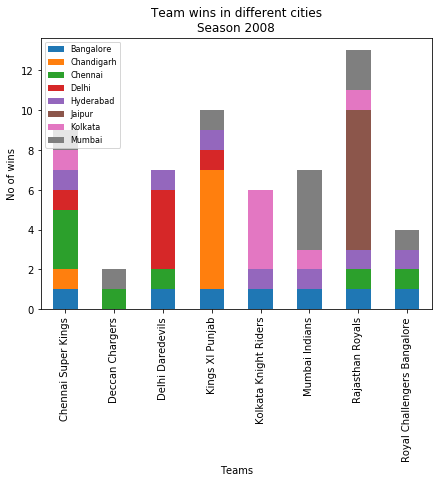

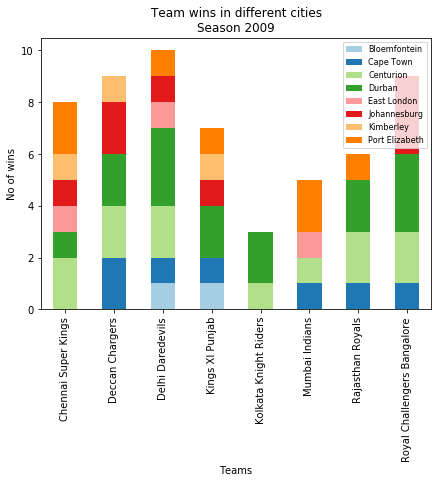

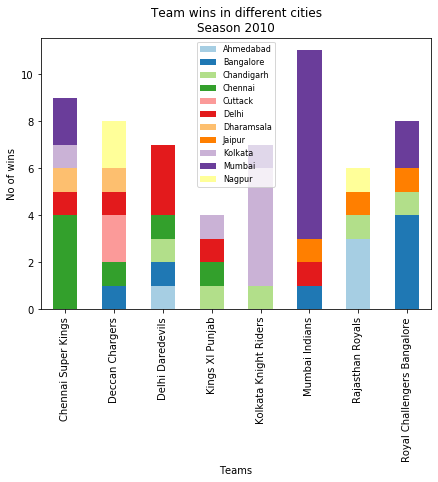

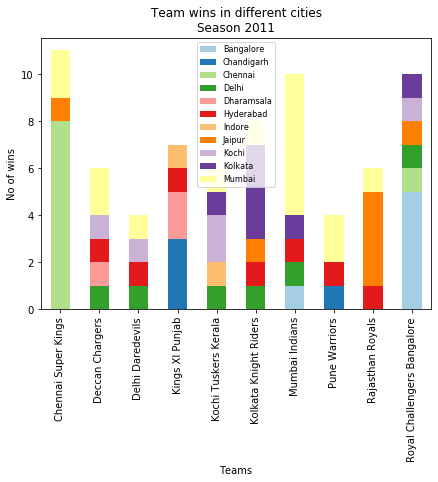

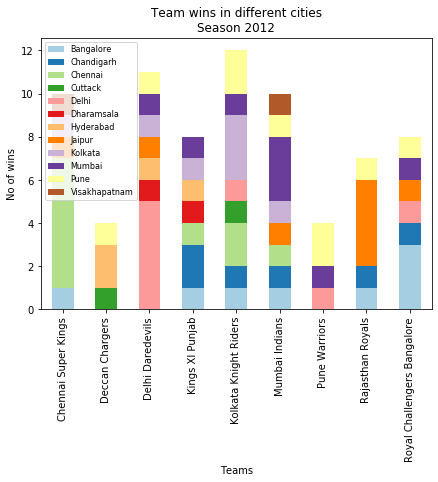

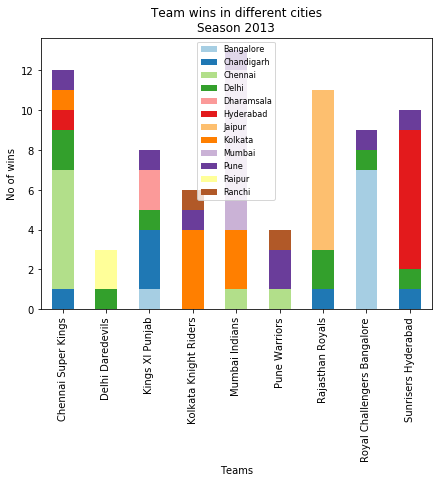

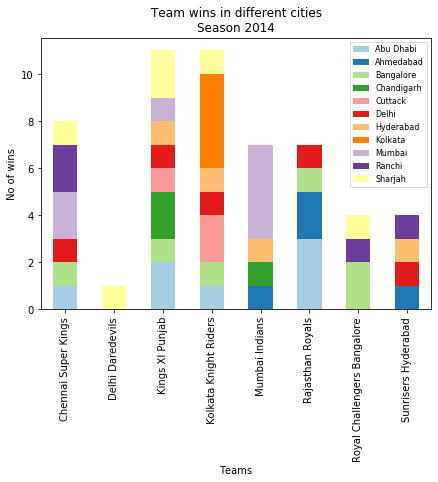

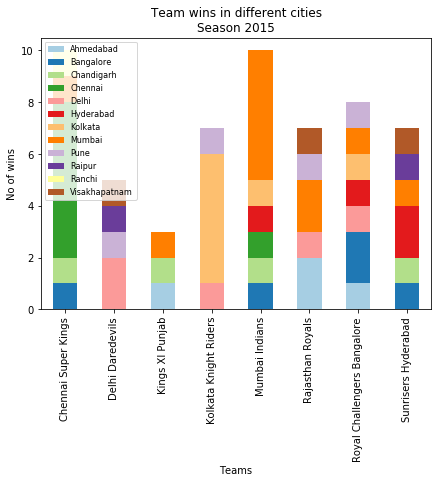

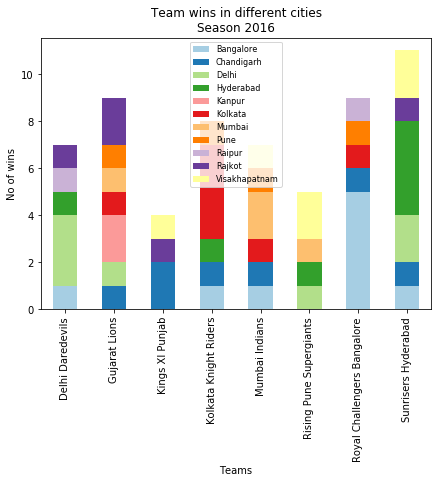

In [0]:
#No of wins by team and season in each city
x, y = 2008, 2017
while x < y:
    wins_percity = matches_agg[matches_agg['season'] == x].groupby(['winner', 'city'])['match_id'].count().unstack()
    plot = wins_percity.plot(kind='bar', stacked=True, title="Team wins in different cities\nSeason "+str(x), figsize=(7, 5))
    sns.set_palette("Paired", len(matches_agg['city'].unique()))
    plot.set_xlabel("Teams")
    plot.set_ylabel("No of wins")
    plot.legend(loc='best', prop={'size':8})
    x+=1

# Plotting the performance of top 5 batsmen over seasons¶
V.Kohli show a steady improvement over season and C. Gayle and SK Raina show a slump

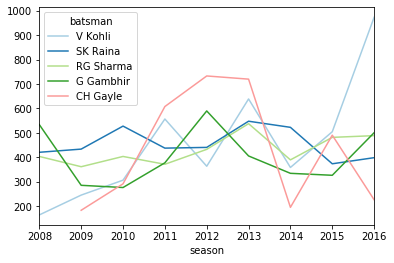

In [0]:
batsman_runsperseason = batsmen.groupby(['season', 'batting_team', 'batsman'])['batsman_runs'].sum().reset_index()
batsman_runsperseason = batsman_runsperseason.groupby(['season', 'batsman'])['batsman_runs'].sum().unstack().T
batsman_runsperseason['Total'] = batsman_runsperseason.sum(axis=1) #add total column to find batsman with the highest runs
batsman_runsperseason = batsman_runsperseason.sort_values(by = 'Total', ascending = False).drop('Total', 1)
ax = batsman_runsperseason[:5].T.plot()

# Percentage of total runs scored through boundaries for each batsman
The average for top batsmen is around 58-60% with exception of CH Gayle at 76%. Interestingly, MS Dhoni who is known for helicopter shots(6s) gets close to 45% of his runs through singles

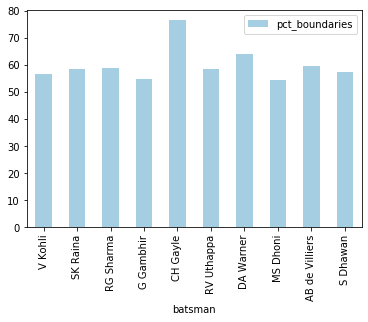

In [0]:
batsman_runs = batsmen.groupby(['batsman'])['batsman_runs', '4s', '6s'].sum().reset_index()
batsman_runs['4s_6s'] = batsman_runs['4s'] * 4 + batsman_runs['6s'] * 6
batsman_runs['pct_boundaries'] = np.round(batsman_runs['4s_6s'] / batsman_runs['batsman_runs'] * 100, 2)
batsman_runs = batsman_runs.sort_values(by = 'batsman_runs', ascending = False)
batsman_runs[:10].plot(x= 'batsman', y = 'pct_boundaries', kind = 'bar')

# Performance of top bowlers over seasons
Malinga is the highest wicket taken in IPL so far

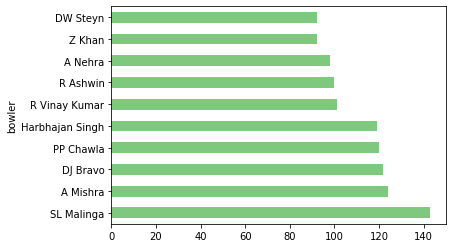

In [0]:
bowlers_wickets = bowlers.groupby(['bowler'])['wickets'].sum()
bowlers_wickets.sort_values(ascending = False, inplace = True)
bowlers_wickets[:10].plot(x= 'bowler', y = 'runs', kind = 'barh', colormap = 'Accent')

# Extra runs conceded by bowlers

In [0]:
bowlers_extras = bowlers.groupby(['season', 'bowler'])['extras'].sum().unstack().T
bowlers_extras['Total'] = bowlers_extras.sum(axis=1)
bowlers_extras.sort_values('Total', ascending = False, inplace = True)
bowlers_extras.head()

season,2008,2009,2010,2011,2012,2013,2014,2015,2016,Total
bowler,,,,,,,,,,
SL Malinga,NaN,31.0,24.0,22.0,19.0,15.0,9.0,19.0,NaN,139.0
P Kumar,14.0,14.0,22.0,11.0,22.0,18.0,1.0,14.0,18.0,134.0
DW Steyn,24.0,5.0,29.0,13.0,10.0,22.0,6.0,2.0,1.0,112.0
JA Morkel,26.0,13.0,13.0,11.0,18.0,6.0,9.0,2.0,5.0,103.0
RP Singh,17.0,24.0,16.0,14.0,15.0,12.0,NaN,NaN,4.0,102.0


# Player of the match
See who has won the Player of the match award maximum number of times

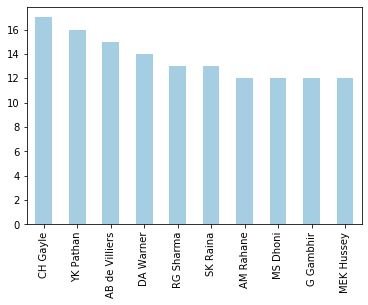

In [0]:
matches['player_of_match'].value_counts()[:10].plot(kind = 'bar')

# Impact of toss on the match outcome

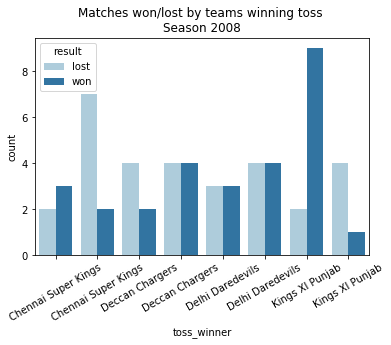

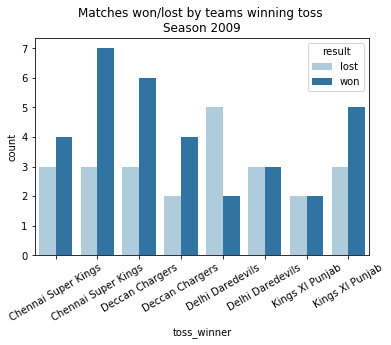

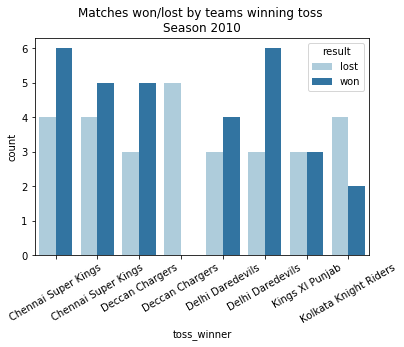

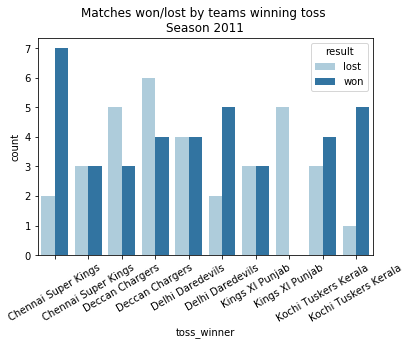

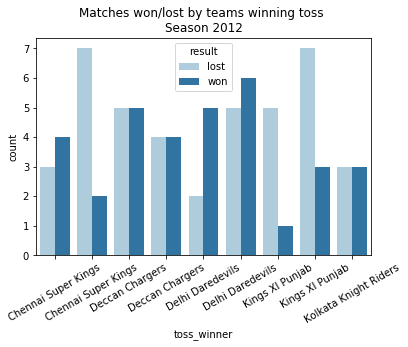

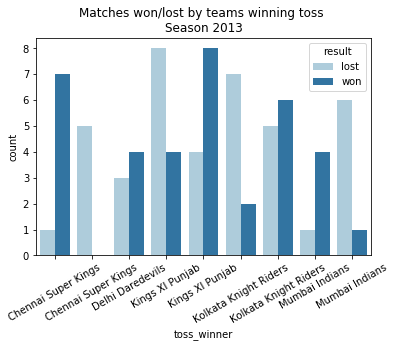

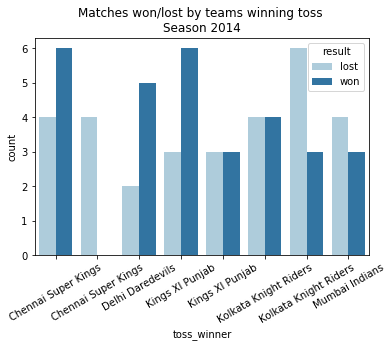

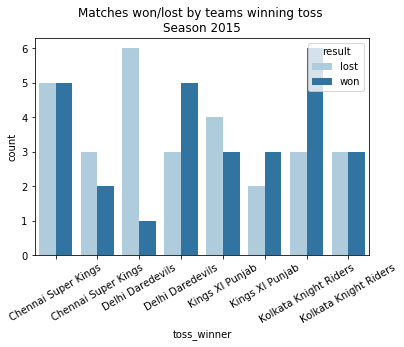

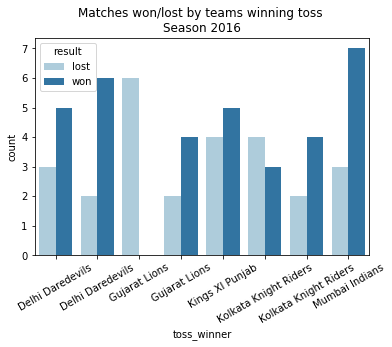

In [0]:
toss = matches_agg.groupby(['season', 'toss_winner']).winner.value_counts().reset_index(name = 'count')
toss['result'] = np.where(toss.toss_winner == toss.winner, 'won', 'lost')
toss_result = toss.groupby(['season', 'toss_winner','result'])['count'].sum().reset_index()

for x in range(2008, 2017, 1):
    toss_result_x = toss_result[toss_result['season'] == x]
    plot = sns.barplot(x="toss_winner", y="count", hue="result", data=toss_result_x)
    plot.set_title('Matches won/lost by teams winning toss \nSeason ' +str(x))
    plot.set_xticklabels(toss_result_x['toss_winner'],rotation=30)
    plt.show()
    x+=1